#### Random Forest Model 
- Uses ensemble of decision trees.
- Breaking whole bunch of decision trees and putting them together.
- Increases prediction accuracy  
PRO   
- Reduces over fitting - which may not be representative of true population
- Reduces Bias - i.e. not evenly split in training.

Need parameters:
- Node Size
- Number of Trees 
- Number of Features 

The number of estimators - number of decision trees used to build the ensemble model. 

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline


In [2]:
########
## READ IN CSV fraud_det_dig_df
# fraud_df = pd.read_csv("../Resources/fraud_det_dig_df.csv")


## Create additional step if SAMPLING only.
## READ IN CSV fraud_det_dig_df
fraud_det_df = pd.read_csv("../Resources/fraud_det_dig_df.csv")
fraud_det_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER,Destination
0,1,181.00,181.0,0.0,0.0,0.00,1,0,1,1,1,1.00,-1.0,0,0,1,0
1,1,181.00,181.0,0.0,21182.0,0.00,1,0,1,1,1,1.00,-1.0,0,1,0,1
2,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,1,1,1,14.95,-1.0,1,1,0,2
3,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1,1,1,305.40,-1.0,1,0,1,3
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,1,1,28.77,-1.0,1,0,1,4


In [3]:
## Create Sample of data to work with
# Determine the proportions of 'isFraud' values in the DataFrame
fraud_proportions = fraud_det_df['isFraud'].value_counts(normalize=True)

# Calculate the number of samples needed for each 'isFraud' value
sample_size = 100000
sample_per_is_fraud = (fraud_proportions * sample_size).astype(int)

# Use the 'groupby' function to take a proportional sample
fraud_df = fraud_det_df.groupby('isFraud').apply(lambda x: x.sample(sample_per_is_fraud[x.name]))

# Reset the index of the sampled DataFrame
fraud_df.reset_index(drop=True, inplace=True)
fraud_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER,Destination
0,212,19789.21,161643.33,141854.11,1215551.76,1235340.97,0,0,20,9,2,0.12,-0.12,0,1,0,88046
1,404,206697.15,206697.15,0.00,1497380.31,1704077.46,0,0,20,17,3,1.00,-1.00,1,1,0,210055
2,205,152120.76,33634.00,0.00,1101575.78,1253696.55,0,0,13,9,2,4.52,-1.00,1,1,0,97727
3,41,238136.27,238136.27,0.00,5870561.52,6361373.40,0,0,17,2,1,1.00,-1.00,1,1,0,2583
4,308,167594.24,167594.24,0.00,185508.87,353103.10,0,0,20,13,2,1.00,-1.00,1,1,0,227847


In [4]:
# Define target vector
# use reshape to convert y into 2-dimensional column vector for machine learning.
y = fraud_df['isFraud'].values.reshape(-1, 1)
y[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [5]:
# Define features Set
X = fraud_df.copy()
X.drop('isFraud', axis=1, inplace =True)
X.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,hour,day,week,trans_weight,bal_change_per,large_transaction,type_CASH_OUT,type_TRANSFER,Destination
0,212,19789.21,161643.33,141854.11,1215551.76,1235340.97,0,20,9,2,0.12,-0.12,0,1,0,88046
1,404,206697.15,206697.15,0.00,1497380.31,1704077.46,0,20,17,3,1.00,-1.00,1,1,0,210055
2,205,152120.76,33634.00,0.00,1101575.78,1253696.55,0,13,9,2,4.52,-1.00,1,1,0,97727
3,41,238136.27,238136.27,0.00,5870561.52,6361373.40,0,17,2,1,1.00,-1.00,1,1,0,2583
4,308,167594.24,167594.24,0.00,185508.87,353103.10,0,20,13,2,1.00,-1.00,1,1,0,227847


In [6]:
# Perform train-test split on the original DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
##########Scaling Data before underbalancing applied
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

------------------------------------------
### Fitting the Random Forest Model
- Model 1
-----------------------------------------------


In [8]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [9]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

Making Preductions Using Random Forest Model

In [10]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

Model1 Evaluation 

In [11]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [12]:
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
cm

array([[19932,     2],
       [   20,    46]], dtype=int64)

In [13]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,19932,2
Actual 1,20,46


Accuracy Score : 0.9989
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19934
           1       0.96      0.70      0.81        66

    accuracy                           1.00     20000
   macro avg       0.98      0.85      0.90     20000
weighted avg       1.00      1.00      1.00     20000



#### Feature Importance

In [14]:
# Get the feature importance array
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.20074262737907156, 'newbalanceDest'),
 (0.13601159127121512, 'oldbalanceDest'),
 (0.09439857856491607, 'oldbalanceOrg'),
 (0.08378820006328784, 'amount'),
 (0.0823024511702624, 'type_CASH_OUT'),
 (0.07651836799578267, 'type_TRANSFER'),
 (0.07365550821533808, 'Destination'),
 (0.06254740339364019, 'step'),
 (0.05994651756481346, 'hour'),
 (0.04239405265983471, 'day')]

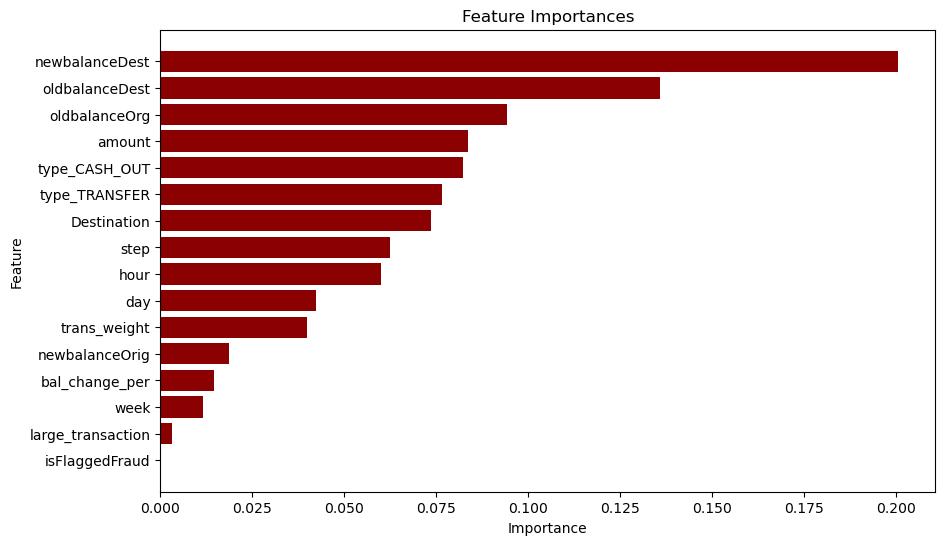

In [15]:
# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})

# Sort the DataFrame by importance values in ascending order to rank features from top to bottom
importances_sorted = importances_df.sort_values(by='Importance')

# Plot the feature importances with dark red color scheme
plt.figure(figsize=(10, 6))
plt.barh(importances_sorted['Feature'], importances_sorted['Importance'], color='darkred')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
